In [37]:
# A rewrite of the code to make it easier to deal with. 
# We now allow for a multi-grid solver with uneven lengths and different resolutions.
# State vector: [t, ξ, p_2, a_4, S0], var_vec.
# var_vec: Phi, S, Sdot, PhiDot, A.
# 
# T = BigFloat;
# setprecision(T,256)

T = Float64;

# --------------------------------------------------------------
#  Struct definition: this holds all variables at a grid point.
# --------------------------------------------------------------/

struct PDEVars{T}
    Phi::T
    S::T
    Sdot::T
    Phidot::T
    A::T
    PhiZ::T
    SZ::T
    SdotZ::T
    PhidotZ::T
    AZ::T
    PhiZZ::T
    SZZ::T
    SdotZZ::T
    PhidotZZ::T
    AZZ::T
    z::T
    LN::T
    t::T
    X::T
    p2::T
    a4::T
    DS0::T
    DS1::T
    DS2::T
    DS3::T
    DS4::T
end

using Plots
using Parameters: @unpack

include("cheb.jl")
include("Equation expressions/ODECoeffExpr.jl");
include("Equation expressions/DynamicS0Expr.jl");
include("Equation expressions/CosmoTimeStepExpr.jl");
include("Equation expressions/CosmoConstrExpr.jl");
include("solvers.jl")

#Properties of this simulation:

# global const H = T(1);
# global const Om = T(4);
# global const tstar = 1;
global const beta = T(1/16);


# tmax = 5/H + tstar;


global const GBd = pi * T(1/2500);
global const LBd = T(-1/2);
global const M = T(1.);

global const z_boundaries = [zero(T), T(0.1),T(0.25), T(0.4),T(0.52)]; #Boundaries of grid domains.
global const domain_sizes = [15, 15, 15, 15]; #sizes of all domains.
global const Ndom = length(domain_sizes);
global const N = sum(domain_sizes);

global const zero_var = [zeros(T,n) for n in domain_sizes]; #Helpful for getting arrays of the right shape


diff2_mats, diff1_mats, grids, damp_mats = MultiGridChebyshev(z_boundaries,domain_sizes);

Vfun(x) = ( -576. - 288. * x^2 - 64. * x^4 + 22. * x^6 - x^8) / 192.;
DV(x) = - x * (144. + 64. * x^2 - 33. * x^4 + 2. * x^6) / 48.;

In [38]:


global domAH = 4;
global indAH = 11;

global zAH = grids[domAH][indAH];
display(zAH)


0.497409388111524

In [39]:
using Serialization
readin = []

open("Data files/FlatInitialData.dat","r") do io
    push!(readin,deserialize(io));
end

init_params = toFormat(readin[1][1]);
init_params[ind_t] = 0;
init_params[ind_S1] = DS1f(init_params);
InitVar = toFormat(readin[1][2]);

In [40]:
DS1f(init_params)

2.2223002279350004

In [41]:
Var = copy(InitVar)

VarZ,VarZZ = ComputeDerivatives(Var);

for ii in 1:500
    Var[ind_s] = LinearSolveODE(1, init_params, Var, VarZ, VarZZ);
    VarZ[ind_s] = ComputeSingleDerivative(Var[ind_s]);
    VarZZ[ind_s] = ComputeSingleDerivative(Var[ind_s], deg=2);

    Var[ind_sdot] = LinearSolveODE(2, init_params, Var, VarZ, VarZZ);
    VarZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot]);
    VarZZ[ind_sdot] = ComputeSingleDerivative(Var[ind_sdot], deg=2);

    newX = CorrectXi(init_params, Var);
    print("\rX = $newX");
    flush(stdout);

    init_params[ind_X] = newX;
    init_params[ind_S1] = DS1f(init_params);
end

InitVar = ComputeBulk(init_params, Var);

X = 2.5860396520589683

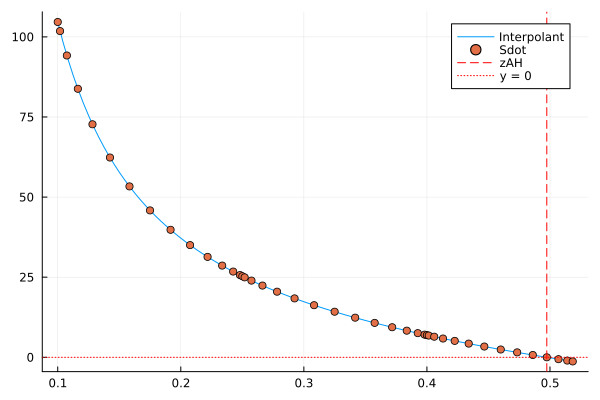

In [42]:
fig = PlotSdot(init_params,InitVar);
display(fig)

In [43]:
dt = T(.00005);
tmax = 3.5;


outfile = [];
monitorfile = [];

FinalParams, VarFinal = Evolve(init_params,InitVar, tmax, dt, 20, outfile, monitorfile);

# close(outfile);
# close(monitorfile);

◓ time = 3.499, constraint violation = 3.404,  Sdot at zAH = -0.009    Time: 0:01:32mm

In [49]:
time_arr = [x[1] for x in monitorfile];
param_arr = [x[2] for x in monitorfile];
X_arr = [x[ind_X] for x in param_arr];
mom_arr = [x[4] for x in monitorfile];
hubble_arr=[x[ind_S1]/x[ind_S0] for x in param_arr];

dtX_arr = [BackwardsTimeDerivative(X_arr[ind-4], X_arr[ind-3], X_arr[ind-2], X_arr[ind-1], X_arr[ind], time_arr[2]) for ind in 5:length(X_arr)];
temp_arr=[Temperature(param_arr[ind], outfile[ind][ind_a][domAH], outfile[ind][ind_phi][1], dtX_arr[ind-4]) for ind in 5:length(time_arr)];

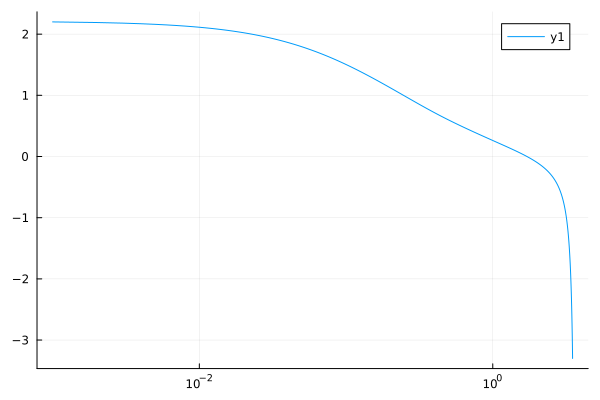

In [50]:
plot(time_arr[2:end],hubble_arr[2:end],xscale=:log10)

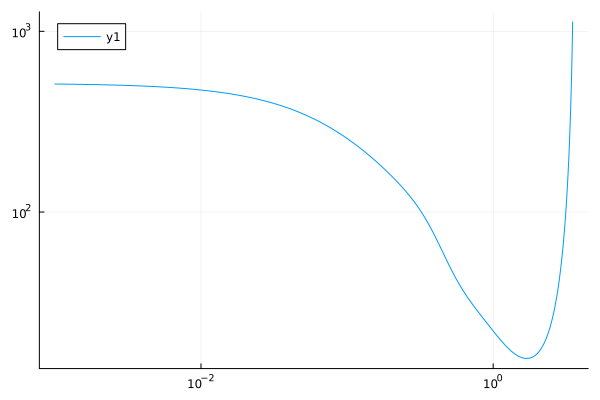

In [48]:
plot(time_arr[2:end],mom_arr[2:end], yscale=:log10,xscale=:log10)

In [ ]:
# neg_time=copy(time_arr);
# neg_temp =copy(temp_arr);

In [ ]:
# zero_time = copy(time_arr);
# zero_temp = copy(temp_arr);

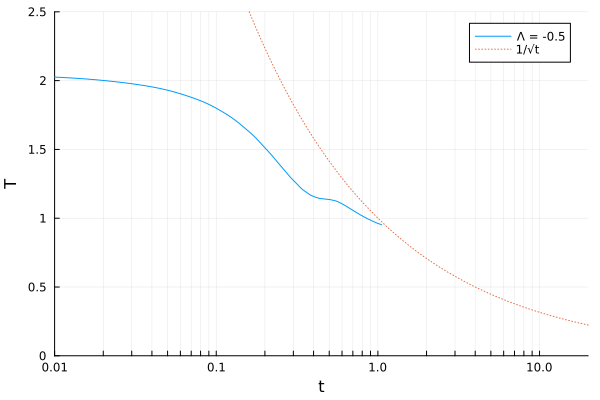

In [36]:
fig = plot(time_arr[5:end],temp_arr/(4*pi),xlims=[0.01,20],xscale=:log10,ylims=[0,2.5], label = "Λ = -0.5");
# plot!(fig, neg_time[5:end],neg_temp/(4*pi), label = "Λ = -0.5")
plot!(fig, x->1/sqrt(x), line=:dot, label = "1/√t")
xtick_vals = vcat(0.01:0.01:0.1,0.2:0.1:1,2:10);
xlab(val) = (val in (0.01,0.1,1,10) ? string(val) : "");
xtick_labels = [xlab(val) for val in xtick_vals];
xticks!(fig, (xtick_vals, xtick_labels))
yticks!(fig, ((0:.5:2.5),["0", "0.5", "1", "1.5", "2", "2.5"]))
xlabel!(fig, "t");
ylabel!(fig, "T")

In [165]:
savefig(fig, "dynamic_temperature.png")

"/Users/jankozuszek/Documents/Holography with dynamic boundary/Reproducing-Dynamic-Holo/dynamic_temperature.png"

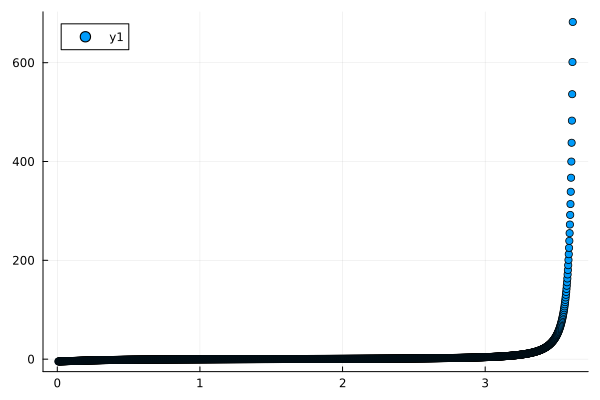

In [118]:
scatter(time_arr[5:end], dtX_arr)

In [107]:
length(monitorfile)

1808

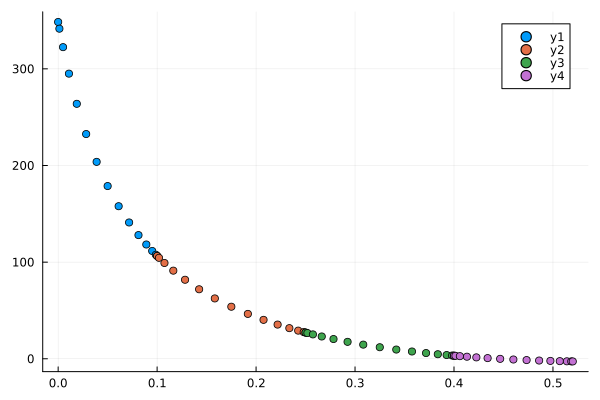

In [108]:
scatter(grids,outfile[1800][1])

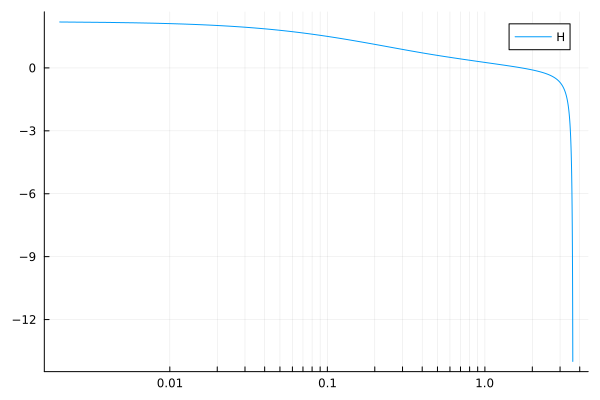

In [80]:
fig = plot([x[1] for x in monitorfile[2:end]],[x[2][ind_S1]/x[2][ind_S0] for x in monitorfile[2:end]],xscale=:log10, label="H")
xtick_vals = vcat(0.01:0.01:0.1,0.2:0.1:1,2:4);
xlab(val) = (val in (0.01,0.1,1) ? string(val) : "");
xtick_labels = [xlab(val) for val in xtick_vals];
xticks!(fig, (xtick_vals, xtick_labels))

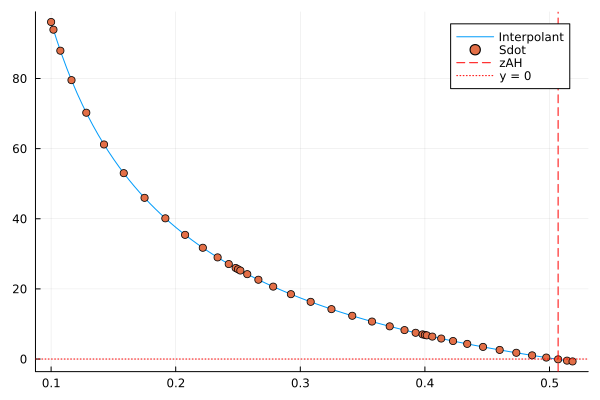

In [110]:
ind =1808;
fig = PlotSdot(monitorfile[ind][2],outfile[ind]);
# title!(fig, string("time = ",format(monitorfile[ind][1],precision=2)))
display(fig)

In [81]:
function DS1_roots(params)

 t, X, p2, a4, DS0 = params;
co0 = ((-27*LBd)/(GBd*M^2) + 3*(-11*LBd + (54*a4)/M^2 - 14*M^2 + 72*beta*M^2 + (72*p2)/M - 72*X^2) + 2*GBd*(-189*a4 + 17*M^4 + 132*beta*M^4 - 60*M*p2 + 60*M^2*X^2))/48;
co1 = (27 + GBd*(9*LBd - 24*M^2) + GBd^2*(-54*a4 + 19*M^4 - 72*beta*M^4 - 72*M*p2 + 72*M^2*X^2))/(16*DS0^2*GBd*M^2);
co2 = (81*(-1 + GBd*M^2))/(32*DS0^4*M^2);
co3 = (27*GBd)/(32*DS0^6*M^2);

DS1eq = poly.Polynomial([co0,co1,co2,co3]);

candidates = poly.roots(DS1eq);

real_and_positive = [real(r) for r in candidates if (abs(imag(r))<1.e-8 && real(r)>0)]; 
sort!(real_and_positive);

return real_and_positive
end

DS1_roots (generic function with 1 method)

In [82]:
root_array = [DS1_roots(x[2]) for x in monitorfile];

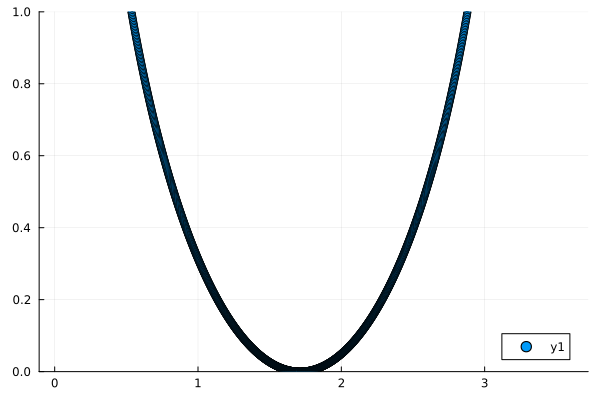

In [84]:
scatter([x[1] for x in monitorfile],[roots[1] for roots in root_array],ylims=[0,1])